<a id='top'></a>
Agnieszka Dutka
# Laboratory 6 -  Karp-Miller-Rosenberg algorithm

Contents:  
[0. KMP and Suffix Tree implementations](#0)  
[1. Dictionary of basic factors](#1)   
[2. KMR algorithm](#2)  
[3. DBF vs Suffix tree Construction time](#3)   
[4. Real DBF size compared to file size](#4)  
[5. DBF vs KMP search times comparison](#5)  
 


<a id='0'></a>
## Suffix Tree

__Structures__

In [3]:
class TreeNode:
    """ Node of Suffix Tree of text @text, representing indexes [@first, @last) """
    def __init__(self, text, first=0, last=0, parent=None): # defaults for root
        self.first = first
        self.last = last
        self.text = text # whole text
        self.parent = parent
        self.children = {}
        self.slink = None
         
    @property
    def length(self):
        return self.last - self.first       
    
    @property
    def label(self):
        return self.text[self.first : self.last]
    
    def add(self, first: int, last: int):
        child = TreeNode(self.text, first, last, self)
        self.children[self.text[first]] = child # add new child to parent
        return child
    
    def split(self, offset):
        new_parent_last = self.first+offset
        new_parent = TreeNode(self.text, self.first, new_parent_last, self.parent)
        new_parent.children[self.text[new_parent_last]] = self
        self.parent.children[self.text[self.first]] = new_parent # change child
        self.first = new_parent_last
        self.parent = new_parent
        return new_parent
        
    def child(self, c):
        return self.children.get(c, None)
    
    def find(self, word: list):
        if word is None:
            return True
        child = self.child(word[0])
        if child is None:
            return False
        offset = 1
        while offset < min(len(word), child.length):
            if word[offset] != child.label[offset]:
                return False
            offset += 1
        if offset == len(word):
            return True
        return child.find(word[offset:])
    
    def __str__(self, indent=0): # recursive display
        return '%s%s\n%s' % (indent * '  ', self.label, ''.join(
                child.__str__(indent + 1)
                for key, child in sorted(self.children.items())
            )
        )


#### McCreight algorithm for Suffix Tree

In [4]:
def slow_find(node, first: int, last: int) -> (TreeNode, TreeNode):
    """ inserts [first, last) into suffix tree starting with @node searching letter by letter.
    @node: represents the potential head in each loop. 
    @return: head and added leaf """
    text = node.text
    offset = 0  # where exactly in the current node we are (offset from node.first)
    while node.child(text[first])  is not None: # looking for child with same first char 
        node = node.child(text[first]) # enter the child
        while node.first + offset < node.last and first<len(text): # traverse nodes letters
            if text[first] == text[node.first + offset]:
                offset += 1
                first += 1
            else:  # we're in the middle of the node
                node = node.split(offset) #CHANGED
                leaf = node.add(first, last)
                return node, leaf
        offset = 0
    leaf = node.add(first, last)
    return node, leaf

def fast_find(node, first: int , last: int) -> (TreeNode, int):
    """ returns furthest node on path [first, lasts) and length it occupies in this node 
    e.g: given: abaabb path: (ab)(aab)b -> node(aab), length=3"""
    assert node is not None
    text = node.text
    length = last - first
    if length == 0:
        return node, length
    node = node.child(text[first])
    while length > node.length: # skip entire node
        first += node.length
        length -= node.length
        node = node.child(text[first])
    return node, length

def McCreight(text):
    text_len = len(text)
    root = TreeNode(text)
    old_head = root
    leaf = root.add(0, text_len)
    for curr_i in range(1, text_len):
        if old_head == root:    # new suffix to attach = old leaf [1:]
            old_head, leaf = slow_find(root, leaf.first + 1, leaf.last)
            continue
        parent = old_head.parent
        if parent == root:      # find "highest" slink (aX - X) where oldHead = aX
            head_slink, h_len = fast_find(parent, old_head.first + 1, old_head.last)
        else:                   # find some lower slink (B-B)
            head_slink, h_len = fast_find(parent.slink, old_head.first, old_head.last)
        if h_len < head_slink.length: # actual head_slink ends in the middle of current head_slink
            head_slink = head_slink.split(h_len) # CHANGED
            new_head = head_slink
            leaf = new_head.add(leaf.first, leaf.last) # copy leaf 
        else:                   # head_slink is a node and has other children already - traverse children
            new_head, leaf = slow_find(head_slink, leaf.first, leaf.last)
        old_head.slink = head_slink # = head_slink
        old_head = new_head

    return root

## Knuth-Morris-Pratt algorithm
[back to top](#top) 

In [5]:
def prefix_function(pattern):
    pi = [0]
    k = 0
    for q in range(1, len(pattern)):
        while(k > 0 and pattern[k] != pattern[q]):
            k = pi[k-1]
        if(pattern[k] == pattern[q]):
            k = k + 1
        pi.append(k)
    return pi

def kmp_string_matching(text, pattern, pi): 
    """ returns positions of found patterns """
    q = 0
    pos = []
    for i in range(0, len(text)):
        while(q > 0 and pattern[q] != text[i]):
            q = pi[q-1]
        if(pattern[q] == text[i]):
            q = q + 1
        if(q == len(pattern)):
            pos.append(i+1-len(pattern))
            q = pi[q-1]
    return pos

def kmp_search(pattern, text):
    pi = prefix_function(pattern)
    return kmp_string_matching(text, pattern, pi)

<a id='1'></a>
## 1. DBF
[back to top](#top) 

In [6]:
def sort_rename(sequence):
    last_entry = None
    index = 0
    pos_to_idx=[None]*len(sequence)
    first_entry={}
    for entry in sorted([(e,i)for i,e in enumerate(sequence)]):
        if(last_entry and last_entry[0] != entry[0]):
            index += 1
            first_entry[index]=entry[1]
        pos_to_idx[entry[1]]=index
        if last_entry is None:
            first_entry[0] = entry[1]
        last_entry = entry
    return pos_to_idx, first_entry

<a id='2'></a>
[back to top](#top) 
## 2. KMR algorithm

based on the fact that:
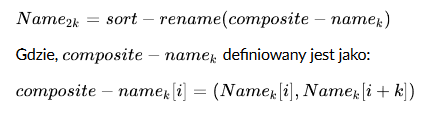

In [137]:
import math

def kmr(text):
    txt_len = len(text)
    factor = math.floor(math.log2(txt_len))
    max_len = 2**factor
    padding_len = 2**(factor+1)-1
    text += "z"*padding_len
    
    pos_to_idx, first_entry = sort_rename(list(text))
    names = {1: pos_to_idx}
    entries = {1: first_entry}
    for i in range(1, factor):
        power = 2**(i-1)
        new_seq = []
        for j in range(len(text)):
            if j+power < len(names[power]):
                new_seq.append((names[power][j], names[power][j+power]))
        pos_to_idx, first_entry = sort_rename(new_seq)
        names[power*2] = pos_to_idx
        entries[power*2] = first_entry
    return names, entries


# simple patern finding using kmr
def kmr_search(pattern, text): 
    names, entries = kmr(pattern+"&"+text)
    matches = []
    if len(pattern) in names.keys():
        name2 = names[len(pattern)]
        for i, val  in enumerate(name2[len(pattern)+1:]):
            if val == name2[0]:
                matches.append(i)
    else:
        factor = math.floor(math.log2(len(pattern)))
        closest_power = 2**factor
        name2 = names[closest_power]
        diff = len(pattern) - closest_power
        for i, val  in enumerate(name2[len(pattern)+1:]):
            if val == name2[0] and name2[diff] == name2[len(pattern)+1+i+diff]:
                matches.append(i)
    return matches


### Quick KMR search

In [138]:
def find_label(names, entries, text, pattern):
    # pad text
    txt_len = len(text)
    factor = math.floor(math.log2(txt_len))
    max_len = 2**factor
    padding_len = 2**(factor+1)-1
    text += "z"*padding_len
    # perform binary search to find label or return none
    labels = [i for i in entries.keys()]
    i, j = 0, len(labels)
    while i+1 < j:
        mid = (i+j)//2
        idx = entries[mid]
        mid_label = text[idx:idx+len(pattern)]
        if(mid_label == pattern):
            return mid
        if mid_label > pattern:
            j = mid
        else:
            i = mid
    idx = entries[mid-1]
    mid_label = text[idx:idx+len(pattern)]
    if(mid_label == pattern):
        return mid-1
    return -1

def quick_kmr_search(text_kmr, text, pattern):
    """ quicker version of kmr algorithm, not requiring building new DBF for pat&text"""
    
    names, entries = text_kmr
    if len(pattern) in names.keys(): # pattern is power of 2
        names, entries = names[len(pattern)], entries[len(pattern)]
        labels = [find_label(names, entries, text, pattern)]
        # search for label
    else:
        factor = math.floor(math.log2(len(pattern)))
        closest_power = 2**factor
        diff = len(pattern) - closest_power
        names, entries = names[closest_power], entries[closest_power]
        labels = [find_label(names, entries, text, pattern[:closest_power]),
                  find_label(names, entries, text, pattern[-closest_power:])]
    for label in labels:
        if(label == -1):
            return []
    matches = []
    for i, val  in enumerate(names):
            if val == labels[0]:
                if len(labels) == 1 or names[i+diff] == labels[1]:
                    matches.append(i)
    return matches
        

__Test run__

In [139]:
text="aabaadddsaasas"
names, entries=kmr(text)
print("names:")
for k,v in names.items():
    print(k,[e+1 for e in v[:len(text)]])
    
print("\npositions:")
for k,v in entries.items():
    print(k,[v[e]+1 for e in range(len(v)-1)])

names:
1 [1, 1, 2, 1, 1, 3, 3, 3, 4, 1, 1, 4, 1, 4]
2 [1, 2, 5, 1, 3, 6, 6, 7, 8, 1, 4, 8, 4, 9]
4 [1, 4, 8, 2, 5, 9, 10, 11, 12, 3, 6, 13, 7, 14]

positions:
1 [1, 3, 6, 9]
2 [1, 2, 5, 11, 3, 6, 8, 9, 14]
4 [1, 4, 10, 2, 5, 11, 13, 3, 6, 7, 8, 9, 12, 14]


In [140]:
text="babbaba"
assert kmr_search("ab", text) == [1,4], print("✘")
print("✓")

✓


<a id='3'></a>
[back to top](#top)
## 3. DBF vs Suffix tree Construction time

In [10]:
from time import perf_counter

def time_eval(func, args,name=None, count=2):
    start = perf_counter()
    res = None
    for i in range(count):
        res = func(*args)
    end = perf_counter()
    avg = (end-start)/count
    if name is not None:
        print(f"{name} average time: {avg}")
        return
    return avg, res 

In [11]:
def get_text(name):
    f = open(name, "r", encoding='utf-8')
    text = f.read()
    text += chr(27) # unique character at the end
    return text

### Comparison for given texts

In [12]:
text = get_text("zad6.txt")

time_eval(kmr, [text], "DBF")
time_eval(McCreight, [text], "Suffix tree")

DBF average time: 0.020206449999989218
Suffix tree average time: 0.0030264000000101987


In [13]:
text = get_text("romeo-i-julia-700.txt")

time_eval(kmr, [text], "DBF")
time_eval(McCreight, [text], "Suffix tree")

DBF average time: 0.5512747999999874
Suffix tree average time: 0.07011264999999867


In [14]:
text = get_text("1997_714.txt")

time_eval(kmr, [text], "DBF", count = 1)
time_eval(McCreight, [text], "Suffix tree", count=1)

DBF average time: 17.533675599999924
Suffix tree average time: 1.8186233999999786


<a id='4'></a>
[back to top](#top)
## 4. Real DBF size compared to file size

In [21]:
import os
import gc
from sys import getsizeof
from queue import Queue
def get_file_size(filename):
    size = os.stat(filename).st_size
    print(f"file size: {size}b")
    return size

def get_struct_size(obj):
    """ get real byte size of given object """
    size = 0
    marked = {id(obj)}
    q = [obj]
    while q:
        size += sum(map(getsizeof, q))
        all_ref = ((id(o), o) for o in gc.get_referents(*q))
        new_ref = {o_id: o for o_id, o in all_ref if o_id not in marked and not isinstance(o, type)}
        q = new_ref.values()
        marked.update(new_ref.keys())
    print(f"struct size: {size}b")
    return size

In [134]:
text = get_text("zad6.txt")
get_file_size("zad6.txt")
names, pos = kmr(text)
get_struct_size(names)
print()

text = get_text("romeo-i-julia-700.txt")
get_file_size("romeo-i-julia-700.txt")
names, pos = kmr(text)
get_struct_size(names)
print()

text = get_text("1997_714.txt")
get_file_size("1997_714.txt")
names, pos = kmr(text)
get_struct_size(names)
print()

file size: 947b
struct size: 264780b

file size: 14208b
struct size: 6580720b

file size: 254133b
struct size: 155564764b



<a id='5'></a>
[back to top](#top)
## 5. DBF vs KMP search times comparison

### Comparison for short text, various patterns

In [145]:
text = get_text("romeo-i-julia-700.txt")
km = kmr(text)

In [146]:
pattern = "SAMSON"
time1, res1 = time_eval(quick_kmr_search ,[km, text, pattern])
time2, res2 = time_eval(kmp_search ,[pattern, text])
print("kmr:",time1, "\n at positions:", res1)
print("kmp:",time2, "\n at positions:", res2)

kmr: 0.002425600000151462 
 at positions: [520, 1716, 1826, 1941, 2057, 2298, 2554, 2788, 2952, 3254, 3343, 3418, 3547, 3683, 3773, 3872, 4037, 4149, 4312, 4364]
kmp: 0.0022372999997060106 
 at positions: [520, 1716, 1826, 1941, 2057, 2298, 2554, 2788, 2952, 3254, 3343, 3418, 3547, 3683, 3773, 3872, 4037, 4149, 4312, 4364]


In [124]:
pattern = "n"
time1, res1 = time_eval(quick_kmr_search ,[km, text, pattern])
time2, res2 = time_eval(kmp_search ,[pattern, text])
print("kmr time:",time1, "\n found:", len(res1))
print("kmp time:",time2, "\n found:", len(res2))

kmr time: 0.0027943499999310006 
 found: 391
kmp time: 0.0024883999999474327 
 found: 391


In [129]:
pattern = "nie"
time1, res1 = time_eval(quick_kmr_search ,[km, text, pattern])
time2, res2 = time_eval(kmp_search ,[pattern, text])
print("kmr time:",time1, "\n found:", len(res1))
print("kmp time:",time2, "\n found:", len(res2))

kmr time: 0.0022580499999094172 
 found: 87
kmp time: 0.00246545000027254 
 found: 87


In [130]:
pattern = "SAMSON\n\nDalipan, Grzegorzu, nie będziem darli pierza."
time1, res1 = time_eval(quick_kmr_search ,[km, text, pattern])
time2, res2 = time_eval(kmp_search ,[pattern, text])
print("kmr time:",time1, "\n found:", len(res1))
print("kmp time:",time2, "\n found:", len(res2))

kmr time: 0.0034470999999030028 
 found: 1
kmp time: 0.004771849999997357 
 found: 1


In [131]:
pattern = """Zapamiętali niesforni poddani,
Bezcześciciele bratniej stali! Cóż to,
Czy nie słyszycie? Ludzie czy zwierzęta,
Co wściekłych swoich gniewów żar gasicie
W własnych żył swoich źródle purpurowym;
Pod karą tortur wypuśćcie natychmiast
Z dłoni skrwawionych tę broń buntowniczą
I posłuchajcie tego, co niniejszym
Wasz rozjątrzony książę postanawia.
Domowe starcia, z marnych słów zrodzone
Przez was, Monteki oraz Kapulecie,
Trzykroć już spokój miasta zakłóciły,
Tak że poważni wiekiem i zasługą
Obywatele werońscy musieli
Porzucić swoje wygodne przybory
I w stare dłonie stare ująć miecze,
By zardzewiałym ostrzem zardzewiałe
Niechęci wasze przecinać. Jeżeli
Wzniecicie kiedyś waśń podobną,
Zamęt pokoju opłacicie życiem.
A teraz wszyscy ustąpcie niezwłocznie.
Ty, Kapulecie, pójdziesz ze mną razem;
Ty zaś, Monteki, przyjdziesz po południu
Na ratusz, gdzie ci dokładnie w tym względzie
Dalsza ma wola oznajmiona będzie.
Jeszcze raz wzywam wszystkich tu obecnych
Pod karą śmierci, aby się rozeszli.
"""
time1, res1 = time_eval(quick_kmr_search ,[km, text, pattern])
time2, res2 = time_eval(kmp_search ,[pattern, text])
print("kmr time:",time1, "\n found:", len(res1))
print("kmp time:",time2, "\n found:", len(res2))

kmr time: 0.0026981500000147207 
 found: 1
kmp time: 0.00393355000005613 
 found: 1


In [132]:
pattern = """GRZEGORZ

/ na stronie do Samsona /

Powiedz: lepszy. Oto nadchodzi jeden z krewnych mego pana.


SAMSON

Nie inaczej; lepszy.


ABRAHAM

Kłamiesz.


SAMSON

Dobądźcie mieczów, jeśli macie serca. Grzegorzu, pamiętaj o swoim pchnięciu.


BENWOLIO

Odstąpcie, głupcy; schowajcie miecze do pochew. Sami nie wiecie, co robicie.

/ Rozdziela ich swoim mieczem. /

/ Wchodzi Tybalt. /


TYBALT

Cóż to? krzyżujesz oręż z parobkami?
Do mnie, Benwolio! pilnuj swego życia.


BENWOLIO

Przywracam tylko pokój. Włóż miecz nazad
Albo wraz ze mną rozdziel nim tych ludzi.


TYBALT

Z gołym orężem pokój? Nienawidzę
Tego wyrazu, tak jak nienawidzę
Szatana, wszystkich Montekich i ciebie.
Broń się, nikczemny tchórzu.

/ Walczą. Nadchodzi kilku przyjaciół obu partii i mieszają się do zwady; wkrótce potem wchodzą mieszczanie z pałkami. /


PIERWSZY OBYWATEL

Hola! berdyszów! pałek! Dalej po nich!
Precz z Montekimi, precz z Kapuletami!

/ Wchodzą Kapulet i Pani Kapulet /


KAPULET

Co za hałas? Podajcie mi długi
Mój miecz! hej!


PANI KAPULET

Raczej kulę; co ci z miecza?


KAPULET

Miecz, mówię! Stary Monteki nadchodzi.
I szydnie swoją klingą mi urąga.

/ Wchodzą Monteki i Pani Monteki. /


MONTEKI

Ha! nędzny Kapulecie!

/ do żony /

                        Puść mnie, pani.


PANI MONTEKI

Nie puszczę cię na krok, gdy wróg przed tobą.

/ Wchodzi Książę z orszakiem. /


KSIĄŻĘ

Zapamiętali niesforni poddani,
Bezcześciciele bratniej stali! Cóż to,
Czy nie słyszycie? Ludzie czy zwierzęta,
Co wściekłych swoich gniewów żar gasicie
W własnych żył swoich źródle purpurowym;
Pod karą tortur wypuśćcie natychmiast
Z dłoni skrwawionych tę broń buntowniczą
I posłuchajcie tego, co niniejszym
Wasz rozjątrzony książę postanawia.
Domowe starcia, z marnych słów zrodzone
Przez was, Monteki oraz Kapulecie,
Trzykroć już spokój miasta zakłóciły,
Tak że poważni wiekiem i zasługą
Obywatele werońscy musieli
Porzucić swoje wygodne przybory
I w stare dłonie stare ująć miecze,
By zardzewiałym ostrzem zardzewiałe
Niechęci wasze przecinać. Jeżeli
Wzniecicie kiedyś waśń podobną,
Zamęt pokoju opłacicie życiem.
A teraz wszyscy ustąpcie niezwłocznie.
Ty, Kapulecie, pójdziesz ze mną razem;
Ty zaś, Monteki, przyjdziesz po południu
Na ratusz, gdzie ci dokładnie w tym względzie
Dalsza ma wola oznajmiona będzie.
Jeszcze raz wzywam wszystkich tu obecnych
Pod karą śmierci, aby się rozeszli.

/ Książę z orszakiem wychodzi. Podobnież Kapulet, Pani Kapulet, Tybalt, obywatele i słudzy. /


MONTEKI

Kto wszczął tę nową zwadę? Mów, synowcze,
Był żeś tu wtedy, gdy się to zaczęło?


BENWOLIO

Nieprzyjaciela naszego pachołcy
I wasi już się bili, kiedym nadszedł;
Dobyłem broni, aby ich rozdzielić:
Wtem wpadł szalony Tybalt z gołym mieczem,
I harde zionąc mi w uszy wyzwanie,
Jął się wywijać nim i siec powietrze,
Które świszczało tylko szydząc z marnych
Jego zamachów. Gdyśmy tak ze sobą
Cięcia i pchnięcia zamieniali, zbiegł się
Większy tłum ludzi; z obu stron walczono,
Aż książę nadszedł i rozdzielił wszystkich.


PANI MONTEKI

Lecz gdzież Romeo? Widział żeś go dzisiaj?
Jakże się cieszę, że nie był w tym starciu.


BENWOLIO

Godziną pierwej, nim wspaniałe słońce
W złotych się oknach wschodu ukazało,
Troski wygnały mię z dala od domu
W sykomorowy ów gaj, co się ciągnie
Ku południowi od naszego miasta.
Tam, już tak rano, syn wasz się przechadzał.
Ledwiem go ujrzał, pobiegłem ku niemu;
Lecz on, spostrzegłszy mię, skrył się natychmiast
I w najciemniejszej ukrył się gęstwinie.
Pociąg ten jego do odosobnienia
Mierząc mym własnym (serce nasze bowiem
Jest najczynniejsze, kiedyśmy samotni),
Nie przeszkadzałem mu w jego dumaniach
I w inną stronę się udałem, chętnie
Stroniąc od tego, co rad mnie unikał.
"""
time1, res1 = time_eval(quick_kmr_search ,[km, text, pattern])
time2, res2 = time_eval(kmp_search ,[pattern, text])
print("kmr time:",time1, "\n found:", len(res1))
print("kmp time:",time2, "\n found:", len(res2))

kmr time: 0.002596750000066095 
 found: 1
kmp time: 0.0032266000002891815 
 found: 1


### Comparison for long text, various patterns

In [147]:
text = get_text("1997_714.txt")
km = kmr(text)

In [157]:
pattern = "Akt"
time1, res1 = time_eval(quick_kmr_search ,[km, text, pattern])
time2, res2 = time_eval(kmp_search ,[pattern, text])
print("kmr:",time1, "\n found:", len(res1))
print("kmp:",time2, "\n found:", len(res2))

assert res1 == res2, "different positions in both algorithms"

kmr: 0.00040949999993245 
 found: 0
kmp: 0.05076195000037842 
 found: 0


In [156]:
pattern = "Art"
time1, res1 = time_eval(quick_kmr_search ,[km, text, pattern])
time2, res2 = time_eval(kmp_search ,[pattern, text])
print("kmr:",time1, "\n found:", len(res1))
print("kmp:",time2, "\n found:", len(res2))

assert res1 == res2, "different positions in both algorithms"

kmr: 0.038850450000154524 
 found: 58
kmp: 0.04154419999986203 
 found: 58


Czas wyszukiwania praktycznie nie zależy od długości wzorca dla algorytmu kmr (z opcją nie wykonywania 
algorytmu dodatkowo dla pat&text).  
Dla długiego tekstu, algorytm kmr (z wcześniej obliczoną strukturą) jest szybszy
od algorytmu kmp.